Dataset shape: (7043, 21)
ROC–AUC: 0.842


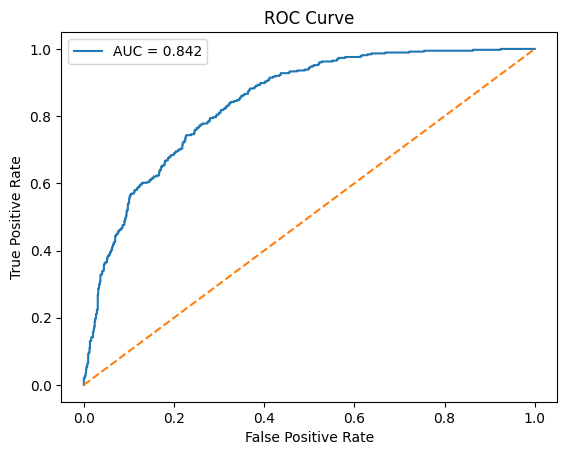


CONFUSION MATRIX
[[617 418]
 [ 36 338]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1035
           1       0.45      0.90      0.60       374

    accuracy                           0.68      1409
   macro avg       0.70      0.75      0.66      1409
weighted avg       0.81      0.68      0.70      1409


Model saved for deployment.


In [1]:
# ============================================================
# CUSTOMER CHURN PREDICTION – LOGISTIC REGRESSION (FINAL)
# Includes: Clean preprocessing, Thresholding, ROC–AUC
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import joblib

# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("CustomerChurn.csv")
print("Dataset shape:", df.shape)

# ------------------------------------------------------------
# 2. BASIC CLEANING
# ------------------------------------------------------------
df = df.drop(columns=["customerID"])

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(
    df["MonthlyCharges"] * df["tenure"]
)

# ------------------------------------------------------------
# 3. TARGET VARIABLE
# ------------------------------------------------------------
y = (df["Churn"] == "Yes").astype(int)
df = df.drop(columns=["Churn"])

# ------------------------------------------------------------
# 4. ENCODING (CATEGORICAL → NUMERIC)
# ------------------------------------------------------------
cat_cols = df.select_dtypes(include="object").columns
X = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# ------------------------------------------------------------
# 5. SCALING (REQUIRED FOR LOGISTIC REGRESSION)
# ------------------------------------------------------------
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# ------------------------------------------------------------
# 6. TRAIN–TEST SPLIT
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ------------------------------------------------------------
# 7. TRAIN LOGISTIC REGRESSION
# ------------------------------------------------------------
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

log_reg.fit(X_train, y_train)

# ------------------------------------------------------------
# 8. PROBABILITY PREDICTION
# ------------------------------------------------------------
y_prob = log_reg.predict_proba(X_test)[:, 1]

# ------------------------------------------------------------
# 9. ROC–AUC (MODEL QUALITY)
# ------------------------------------------------------------
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC–AUC:", round(roc_auc, 3))

# ROC Curve (optional but good)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 10. THRESHOLD SELECTION (BUSINESS CONTROL)
# ------------------------------------------------------------
THRESHOLD = 0.35   # high-recall churn use case
y_pred = (y_prob >= THRESHOLD).astype(int)

print("\nCONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))

print("\nCLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

# ------------------------------------------------------------
# 11. SAVE MODEL FOR DEPLOYMENT
# ------------------------------------------------------------
joblib.dump(log_reg, "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns, "feature_columns.pkl")

print("\nModel saved for deployment.")
